In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mitgcmdata import MITgcmmodel, layers, budgets
reload(layers)
reload(budgets)

%matplotlib inline
plt.rcParams['image.origin'] = 'bottom'

In [2]:
# the controlled run
#ddir = '/glade/scratch/rpa/SOSE/run_matt'
#ddir = '/glade/scratch/rpa/SOSE/run_matt_layers'
ddir = '/data/scratch/rpa/SOSE/run_matt'
N = 1

iter0 = 480
diters= 480
deltaTclock = 900
iters = range(iter0, iter0+diters*N, diters)
iters = [128160,]

layers_name = '1RHO'

m = MITgcmmodel.ModelInstance(output_dir=ddir, default_iter= iters[-1])

/data/scratch/rpa/SOSE/run_matt/XC.meta
/data/scratch/rpa/SOSE/run_matt/XG.meta
/data/scratch/rpa/SOSE/run_matt/YC.meta
/data/scratch/rpa/SOSE/run_matt/YG.meta
/data/scratch/rpa/SOSE/run_matt/DYC.meta
/data/scratch/rpa/SOSE/run_matt/DYG.meta
/data/scratch/rpa/SOSE/run_matt/DXC.meta
/data/scratch/rpa/SOSE/run_matt/DXG.meta
/data/scratch/rpa/SOSE/run_matt/RAC.meta
/data/scratch/rpa/SOSE/run_matt/RC.meta
/data/scratch/rpa/SOSE/run_matt/RF.meta
/data/scratch/rpa/SOSE/run_matt/DRC.meta
/data/scratch/rpa/SOSE/run_matt/DRF.meta
/data/scratch/rpa/SOSE/run_matt/Depth.meta
/data/scratch/rpa/SOSE/run_matt/hFacC.meta
/data/scratch/rpa/SOSE/run_matt/hFacS.meta
/data/scratch/rpa/SOSE/run_matt/hFacW.meta


2160 320  42


/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)


In [3]:
reload(budgets)

# both THETA and SALT budgets
tracer_budgets = {
     'T': budgets.TracerBudget(m,
                'SO_Tbdg5', 'SO_Surf5d', trname='TH',
                swflux_name='oceQsw',
                swflux_fname='../run_np240/SO_Surf5d',
                iters=iters, avg_iters=True, usememmap=True),
     'S': budgets.TracerBudget(m,
                'SO_Sbdg5', 'SO_Surf5d', trname='SLT',
                iters=iters, avg_iters=True, usememmap=True)
}

/data/scratch/rpa/SOSE/run_matt/SO_Tbdg5.0000128160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000128160.meta
/data/scratch/rpa/SOSE/run_matt/../run_np240/SO_Surf5d.0000128160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Sbdg5.0000128160.meta
/data/scratch/rpa/SOSE/run_matt/SO_Surf5d.0000128160.meta


/home/rpa/mitgcmdata/mitgcmdata/budgets.py:231: RuntimeWarning: divide by zero encountered in reciprocal
  (self.m.drf * self.m.hFacC)**-1, 0.)
/home/rpa/mitgcmdata/mitgcmdata/budgets.py:236: RuntimeWarning: divide by zero encountered in reciprocal
  (self.m.drf * self.m.hFacC)**-1, 0.)
-c:12: RuntimeWarning: invalid value encountered in divide
/usr/local/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:802: RuntimeWarning: invalid value encountered in less_equal
  return umath.less_equal(x, self.critical_value)
/home/rpa/mitgcmdata/mitgcmdata/budgets.py:221: RuntimeWarning: divide by zero encountered in reciprocal
  (self.m.drf * self.m.hFacC)**-1, 0.)


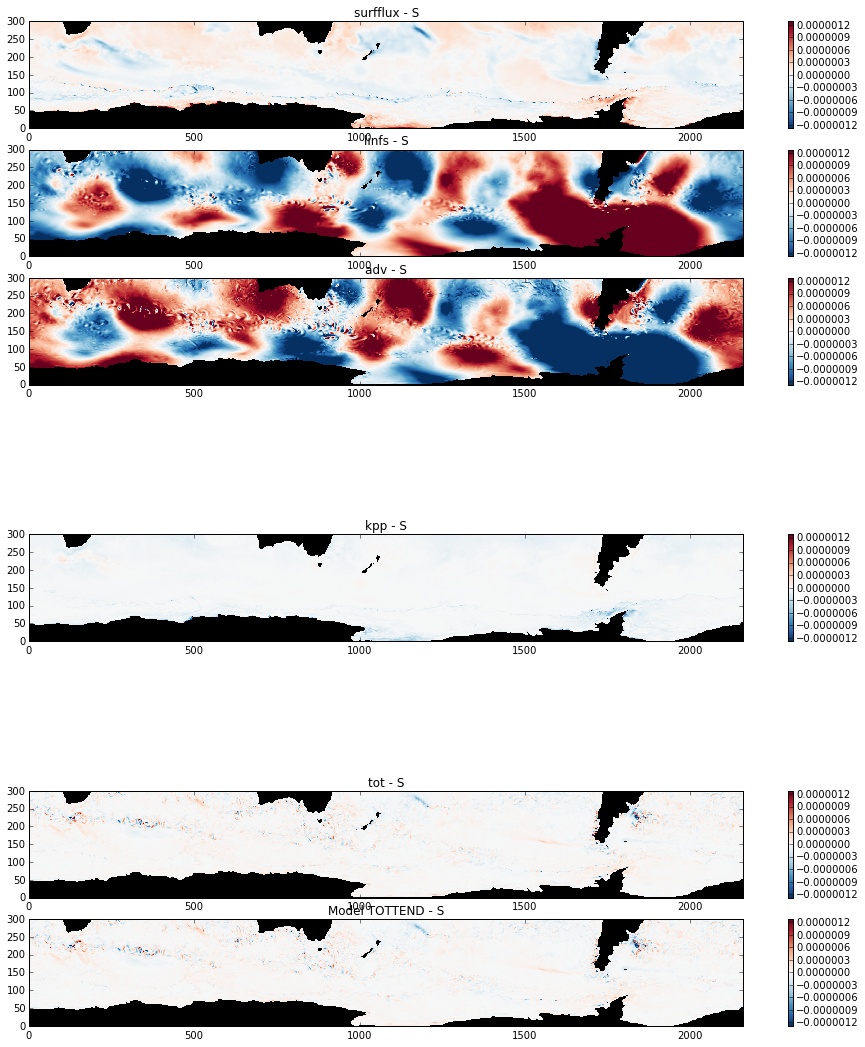

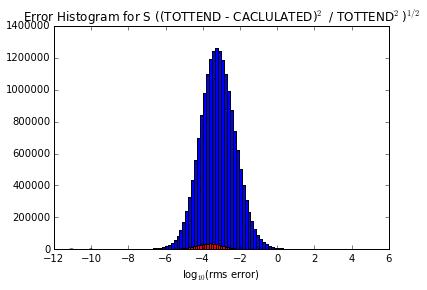

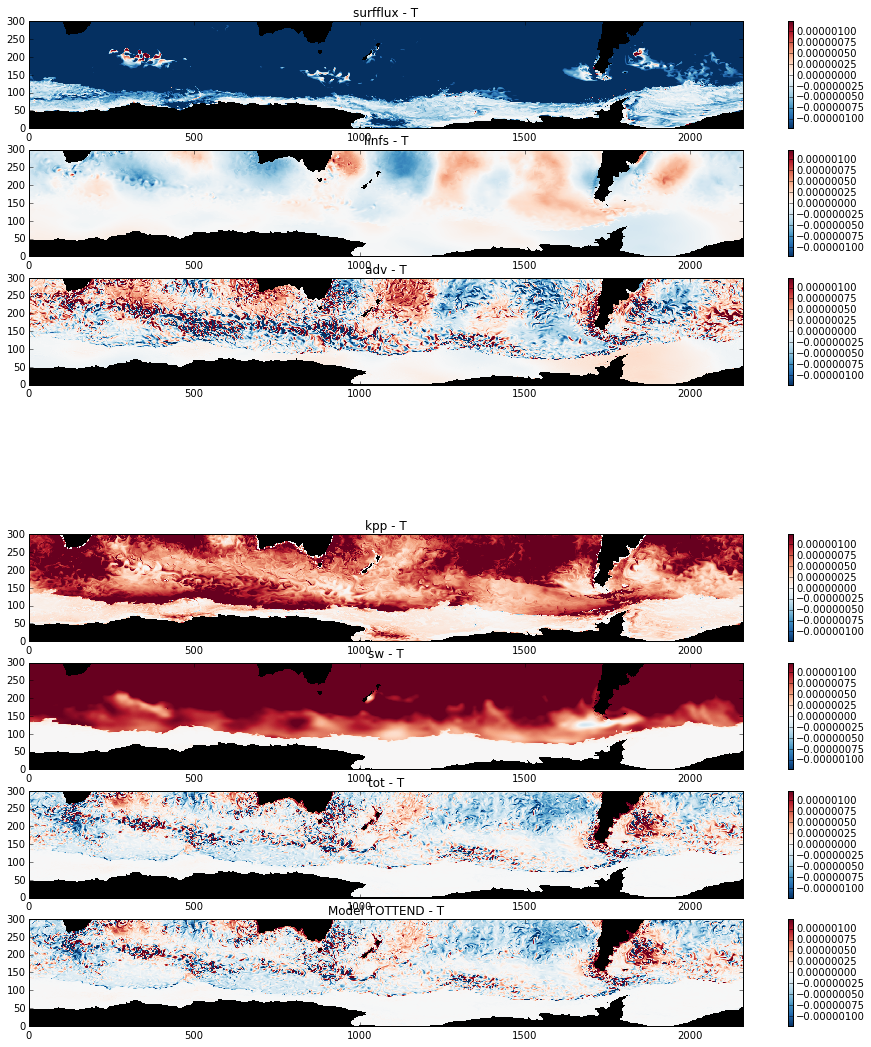

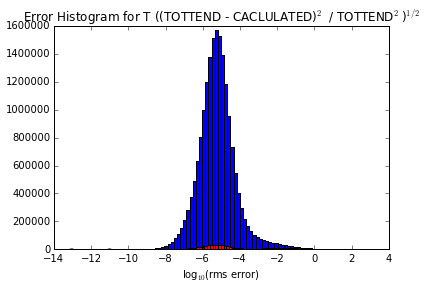

In [4]:
for trname, b in tracer_budgets.iteritems():
    
    #tot_vflux, adv_vflux, diff_vflux = b.net_vertical_flux()
    #tot_mflux, adv_mflux, diff_mflux = b.net_meridional_flux()
    #tot_flux_conv, adv_flux_conv, diff_flux_conv, surf_flux_conv, sw_flux_conv = b.flux_convergence()
    #surf_wmass_conv = b.flux_convergence_surf_wmass()
    c2d, c3d = b.flux_convergence()
    
    tot_flux_conv = c3d['tot']
    err = np.ma.masked_invalid(
            np.sqrt((b.tottend - tot_flux_conv)**2 /
             b.tottend**2 ))[...,:300,:]
    log_err = np.ma.masked_invalid(np.log10(err))

    r = 2*np.median(m.mask_field(c3d['adv']**2)[0].compressed()**0.5)
    if trname=='T':
        r *= 3
    
    #true_surf_flux = surf_flux_conv.copy()
    #if sw_flux_conv is not None:
    #    true_surf_flux += sw_flux_conv[0]
    
    plt.figure(figsize=(16,18))
    
    Nitems = 7
    Nplots = Nitems + 1
    
    for n, k in enumerate(['surfflux', 'linfs']):
        plt.subplot(Nplots, 1, n+1, axisbg='k')
        plt.pcolormesh(np.ma.masked_array(c2d[k], m.mask[0]), cmap='RdBu_r')
        plt.title('%s - %s' % (k, trname))
        plt.xlim([0,m.Nx])
        plt.ylim([0,300])
        plt.clim([-r,r])
        plt.colorbar()
        
    for n, k in enumerate(['adv', 'diff', 'kpp', 'sw', 'tot']):
        if c3d.has_key(k):
            plt.subplot(Nplots, 1, n+3, axisbg='k')
            plt.pcolormesh(m.mask_field(c3d[k])[0], cmap='RdBu_r')
            plt.title('%s - %s' % (k, trname))
            plt.xlim([0,m.Nx])
            plt.ylim([0,300])
            plt.clim([-r,r])
            plt.colorbar()
        

    plt.subplot(Nplots, 1, Nplots, axisbg='k')
    plt.pcolormesh(m.mask_field(b.tottend)[0], cmap='RdBu_r')
    plt.title('Model TOTTEND - %s' % trname)
    plt.xlim([0,m.Nx])
    plt.ylim([0,300])
    plt.clim([-r,r])
    plt.colorbar()

    plt.figure()
    plt.hist(log_err.compressed().ravel(), bins=100);
    plt.hist(log_err[0].compressed().ravel(), bins=100, color='r');
    plt.xlabel(r'log$_{10}$(rms error)')
    plt.title(r'Error Histogram for %s ((TOTTEND - CACLULATED)$^2$ / TOTTEND$^2$)$^{1/2}$' % trname)
    

<matplotlib.colorbar.Colorbar instance at 0x2b710d16a758>

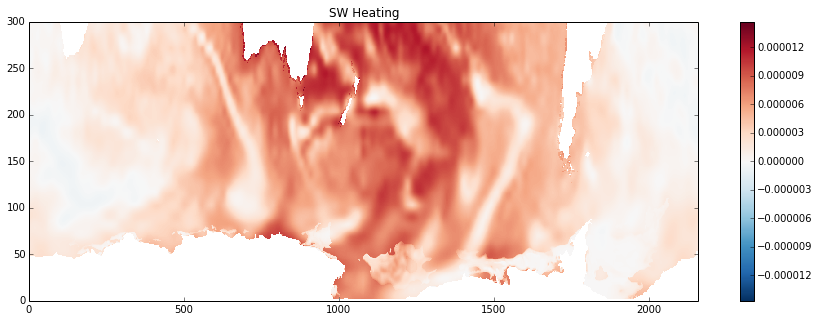

In [68]:
n = 0
plt.figure(figsize=(15,5))
plt.pcolormesh(m.mask_field(sw_flux_conv)[n], cmap='RdBu_r')
plt.title('SW Heating')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-2*r,2*r])
plt.colorbar()

In [42]:
layers_sw = m.rdmds('layers_sw.01',480)

/glade/scratch/rpa/SOSE/run_matt_layers/layers_sw.01.0000000480.meta


<matplotlib.colorbar.Colorbar instance at 0x2b710d3a6518>

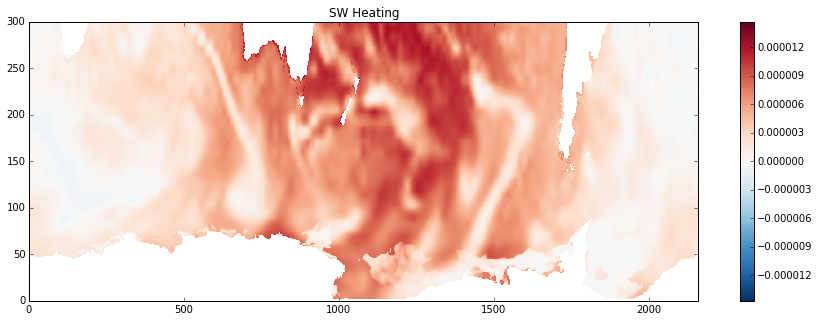

In [69]:
n = 0
plt.figure(figsize=(15,5))
plt.pcolormesh(m.mask_field(layers_sw)[n], cmap='RdBu_r')
plt.title('SW Heating')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-2*r,2*r])
plt.colorbar()

In [70]:
layers_surf = m.rdmds('layers_surfflux.01',480)

/glade/scratch/rpa/SOSE/run_matt_layers/layers_surfflux.01.0000000480.meta


<matplotlib.colorbar.Colorbar instance at 0x2b710d0781b8>

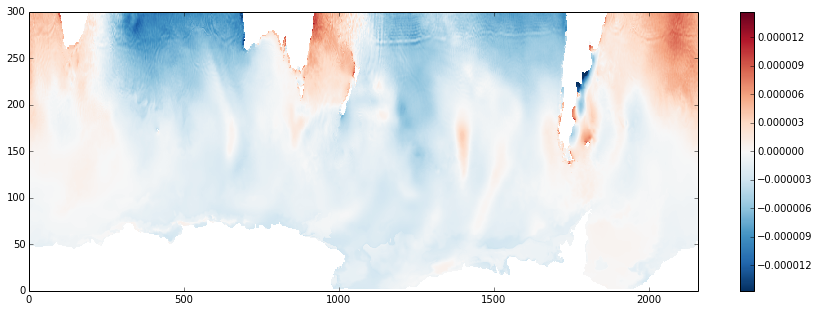

In [81]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(layers_surf[0], m.mask[0]), cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-2*r,2*r])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b710c739098>

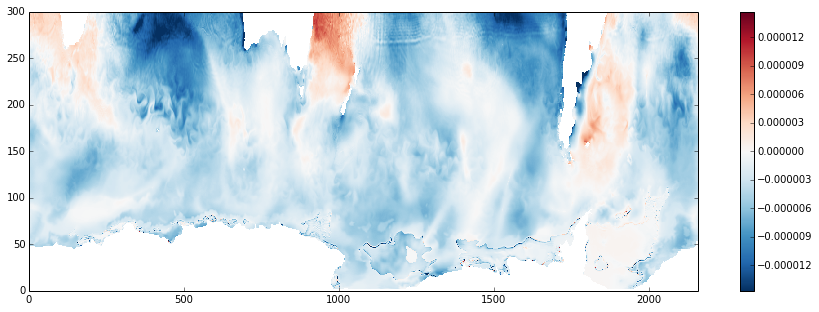

In [83]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(surf_flux_conv, m.mask[0]), cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-2*r,2*r])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b7119b95dd0>

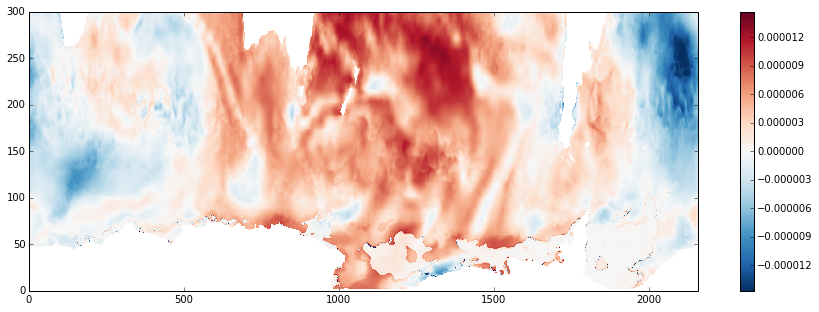

In [86]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(surf_flux_conv-layers_surf[0], m.mask[0]), cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-2*r,2*r])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b7119d30cf8>

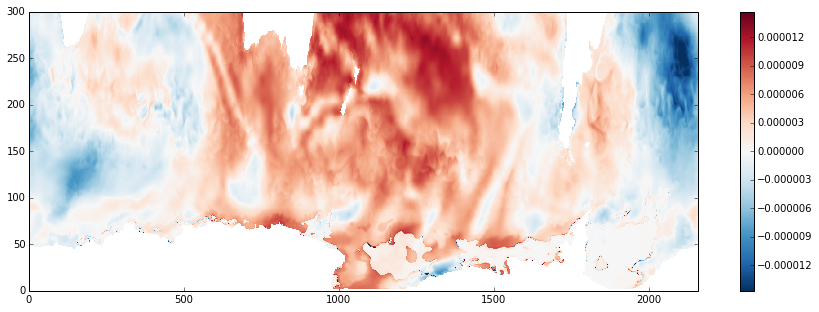

In [91]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(b.surfflux - b.surf_wmass, m.mask[0])/m.drf[0], cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-2*r,2*r])
plt.colorbar()

## layers_surfflux only has the wvelmass component! missing all other fluxes!! ##

In [107]:
# lets look at salinity

b = tracer_budgets['S']
tot_flux_conv, adv_flux_conv, diff_flux_conv, surf_flux_conv, sw_flux_conv = b.flux_convergence()

<matplotlib.colorbar.Colorbar instance at 0x2b717b2bbb90>

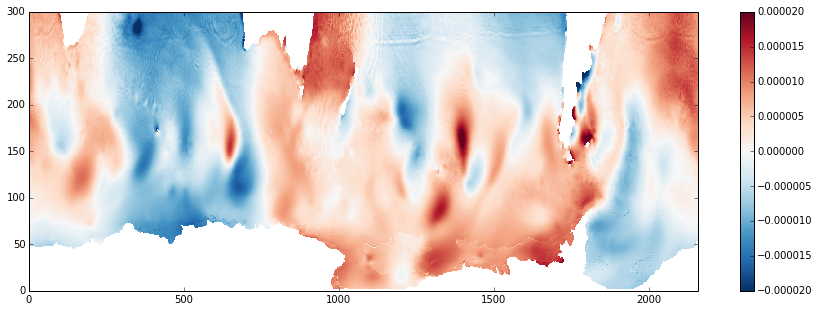

In [110]:
r = 2e-5
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(surf_flux_conv, m.mask[0]), cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-r,r])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b717b3fbd40>

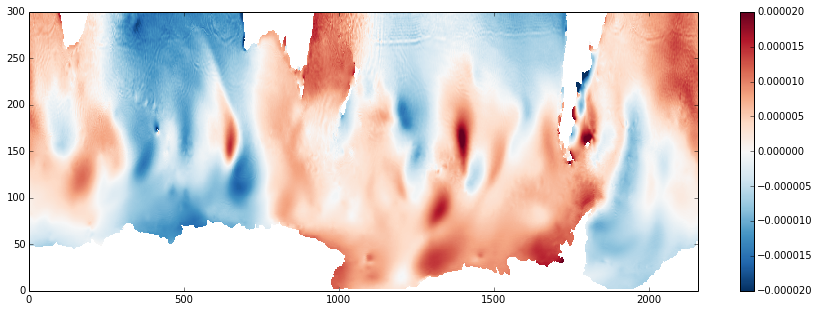

In [111]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(layers_surf[1], m.mask[0]), cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-r,r])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b717ba600e0>

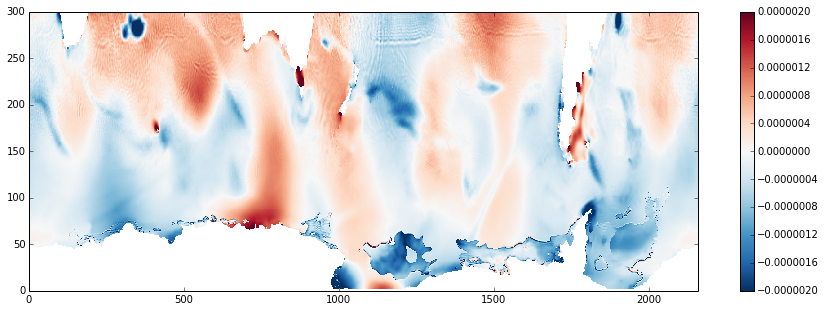

In [117]:
r=2e-6
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(surf_flux_conv-layers_surf[1], m.mask[0]), cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-r,r])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2b717bba2950>

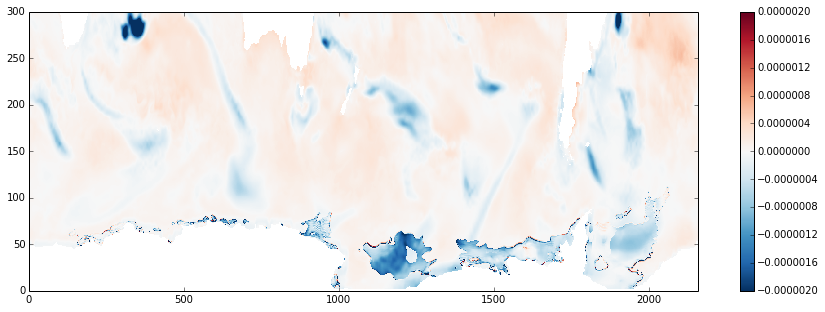

In [118]:
plt.figure(figsize=(15,5))
plt.pcolormesh(np.ma.masked_array(b.surfflux - b.surf_wmass, m.mask[0])/m.drf[0], cmap='RdBu_r')
plt.xlim([0,m.Nx])
plt.ylim([0,300])
plt.clim([-r,r])
plt.colorbar()

## There is still a mismatch in salinity. But it is not the same as for theta. ##

In [17]:
tot_flux_conv.shape

(42, 320, 2160)

In [24]:
len({'a': 3})

1